### Init

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import get_variable_name, upscale_image, rescale_image
from ipywidgets import interact, FloatSlider, IntSlider, fixed, Output, widgets, interactive
from IPython.display import display, clear_output
from rnd.image_viewer import view_image
from ultralytics import YOLOWorld
import os


True

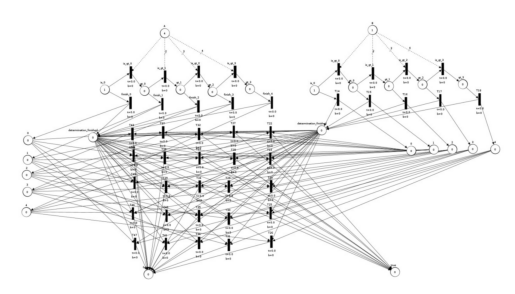

In [5]:
model_dir = '../models' 
os.makedirs(model_dir, exist_ok=True)

image_path = '../assets/else/sunset-lake-landscape-illustration-free-vector.jpg'
image_path = '../assets/else/arrows.png'
# image_path = '../assets/internet/petri_net_5.png'
image_path = '../assets/local/complex_petri_1.jpg'
# image_path = '../assets/local/complex_petri_2_temp.png'
# image_path = '../assets/local/mid_petri_1_temp.png'
# image_path = '../assets/local/simple_petri_1.jpg'
# image_path = '../assets/else/dogs.jpeg'
# image_path = '../assets/else/overlapped.png'
# image_path = '../assets/else/padded_image.png'


image = cv2.imread(image_path)
image = upscale_image(image, 2040)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_inverted = cv2.bitwise_not(image_gray)

plt.imshow(image_gray, cmap='gray')
plt.axis('off') 

image.shape
# save the image to the postprocessed directory
cv2.imwrite(f'../assets/postprocessed/upscaled_image.png', image)

### Color distribution(histogram)

Text(0.5, 1.0, 'Grayscale Histogram')

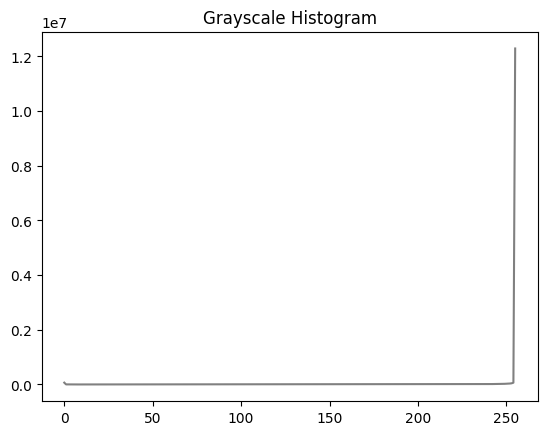

In [3]:
gray_hist = cv2.calcHist([image_gray], [0], None, [256], [0, 256])
plt.plot(gray_hist, color='gray')
plt.title('Grayscale Histogram')

### Testing different thresholding techniques

True

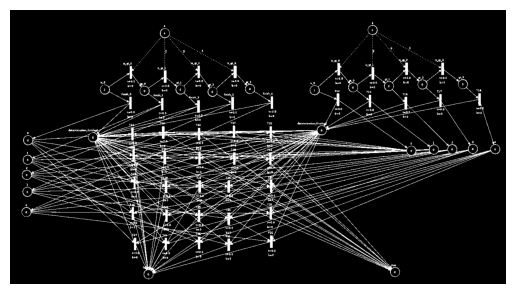

In [72]:
# 1. Basic thresholding
_, basic_thresh = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)

# 2. Otsu's method
_, otsu_thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 3. Adaptive thresholding
adaptive_mean = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 5, 2)
adaptive_gaussian = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)

plt.imshow(otsu_thresh, cmap='gray')
plt.axis('off')

# Save the thresholded images to files
cv2.imwrite(f'../assets/postprocessed/{get_variable_name(basic_thresh)}.png', basic_thresh)
cv2.imwrite(f'../assets/postprocessed/{get_variable_name(otsu_thresh)}.png', otsu_thresh)
cv2.imwrite(f'../assets/postprocessed/{get_variable_name(adaptive_mean)}.png', adaptive_mean)
cv2.imwrite(f'../assets/postprocessed/{get_variable_name(adaptive_gaussian)}.png', adaptive_gaussian)


In [69]:
view_image(f'../assets/postprocessed/{get_variable_name(otsu_thresh)}.png')

Instructions:
- Mouse wheel: Zoom in/out
- Left drag: Pan
- Press 'c': Center image
- Press 'q': Quit


In [70]:
def explore_adaptive_threshold(img):
    """
    Creates an interactive window with trackbars to explore the effects of
    block_size and C parameters on adaptive thresholding.
    
    Args:
        image_path: Path to the input image
    """
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create window
    window_name = "Adaptive Threshold Explorer"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    
    # Define callback function for trackbars
    def on_trackbar_change(val):
        # Get current trackbar values
        block_size = cv2.getTrackbarPos('Block Size', window_name)
        if block_size % 2 == 0:  # Ensure block size is odd
            block_size += 1
        c_value = cv2.getTrackbarPos('C Value', window_name) - 10  # Offset to allow negative values
        
        # Apply adaptive thresholding
        if block_size >= 3:  # Block size must be >= 3
            binary = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV, block_size, c_value
            )
            
            # Display parameter values on the image
            display_img = np.hstack([gray, binary])
            cv2.putText(display_img, f"Block Size: {block_size}, C: {c_value}", 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            
            # Show the results
            cv2.imshow(window_name, display_img)
    
    # Create trackbars
    cv2.createTrackbar('Block Size', window_name, 11, 50, on_trackbar_change)
    cv2.createTrackbar('C Value', window_name, 12, 20, on_trackbar_change)  # 0-20 range, offset by 10 to allow negative values
    
    # Initialize display
    on_trackbar_change(0)
    
    # Wait for key press
    print("Press 'ESC' to close the window")
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC key
            break
    
    cv2.destroyAllWindows()

In [71]:
explore_adaptive_threshold(image)

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


Press 'ESC' to close the window


### Recommended by claude method for finding contours.

In [ ]:
# Load and prepare the image
image = cv2.imread('../../assets/local/complex_petri_2.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# STEP 1: Gaussian blur to reduce noise while preserving edges
# Use a small kernel to avoid blurring thin lines too much
# blurred = cv2.GaussianBlur(image_gray, (3, 3), 0)

# STEP 2: Adaptive thresholding with small block size
binary = cv2.adaptiveThreshold(image_gray, 255, 
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY_INV, 11, 2)

# STEP 3: Morphological operations to connect broken lines
kernel = np.ones((2, 2), np.uint8)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# STEP 4: Find contours
contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, 
                                     cv2.CHAIN_APPROX_SIMPLE)

# STEP 5: Draw contours for visualization
result = np.ones_like(image) * 255 #image.copy()
cv2.drawContours(result, contours, -1, (0, 255, 0), 1)

cv2.imwrite('../../assets/postprocessed/temp.jpg', result)


print(f"Found {len(contours)} contours")

Found 131 contours


### Experimenting with matplotlib and opencv imshow

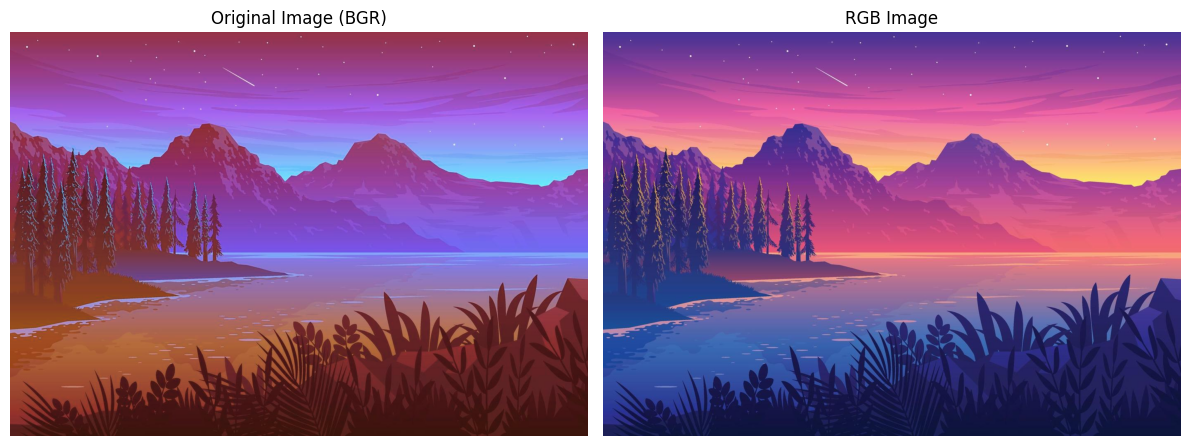

In [2]:
image = cv2.imread('../../assets/else/sunset-lake-landscape-illustration-free-vector.jpg')
img_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image)  # Convert BGR to RGB for correct display
plt.title('Original Image (BGR)')
plt.axis('off')

# Display converted RGB image
plt.subplot(1, 2, 2)
plt.imshow(img_converted)  # img_gray is already in RGB format
plt.title('RGB Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Display images using OpenCV instead of matplotlib

# Create named windows
cv2.namedWindow('Original Image (BGR)', cv2.WINDOW_NORMAL)
cv2.namedWindow('RGB Image', cv2.WINDOW_NORMAL)

# Resize windows (optional)
cv2.resizeWindow('Original Image (BGR)', 800, 600)
cv2.resizeWindow('RGB Image', 800, 600)

# Display the images
cv2.imshow('Original Image (BGR)', image)
cv2.imshow('RGB Image', img_converted)

# Wait for a key press (0 means wait indefinitely)
print("Press any key to close the windows")
cv2.waitKey(0)

# Close all OpenCV windows
cv2.destroyAllWindows()

Press any key to close the windows


### Skeletonizing 

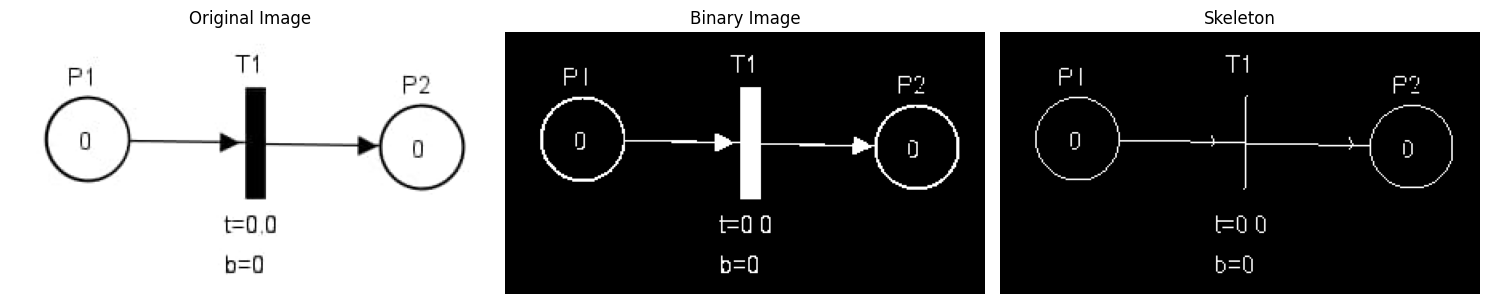

In [11]:
from skimage.morphology import skeletonize
import numpy as np

import matplotlib.pyplot as plt

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to binary (black and white)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Normalize to have 0s and 1s for skeletonize
binary_norm = binary / 255

# Apply skeletonization
skeleton = skeletonize(binary_norm)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(binary, cmap='gray')
axes[1].set_title('Binary Image')
axes[1].axis('off')

axes[2].imshow(skeleton, cmap='gray')
axes[2].set_title('Skeleton')
axes[2].axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(299.5), np.float64(163.5), np.float64(-0.5))

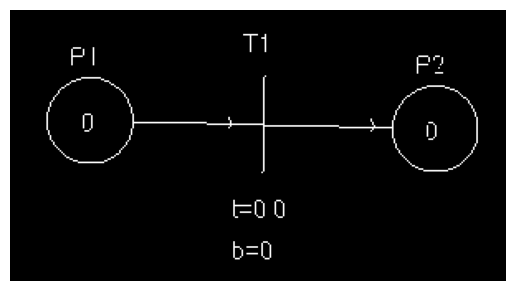

In [12]:
plt.imshow(skeleton, cmap='gray')
plt.axis('off')

### YOLO

In [ ]:
# # Print available classes in your model
# print("Available classes in the model:", model.names)

# # Try with a lower confidence threshold
# results = model(image_path, conf=0.25)  # Lower the confidence threshold

In [41]:
# Initialize the model with custom path
# model_path = os.path.join(model_dir, "yolov8s-world.pt")
model_path = os.path.join(model_dir, "yolov8x-world.pt")

# Initialize a YOLO-World model
model = YOLOWorld(model_path)

# Define custom classes
model.set_classes(["circle"])
model.to('cpu')  # Move model to CPU

# Execute prediction on an image
results = model.predict(image_path, conf = 0.01, device='cpu')

# Display the results
results[0].show()


image 1/1 c:\Users\samoed\Documents\GitHub\diploma_bachelor\src\..\assets\local\complex_petri_1.jpg: 384x640 4 circles, 582.5ms
Speed: 1.7ms preprocess, 582.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


### Arrows 

In [3]:
def preprocess(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)
    img_canny = cv2.Canny(img_blur, 50, 50)
    kernel = np.ones((3, 3))
    img_dilate = cv2.dilate(img_canny, kernel, iterations=2)
    img_erode = cv2.erode(img_dilate, kernel, iterations=1)
    return img_erode

def find_tip(points, convex_hull):
    length = len(points)
    indices = np.setdiff1d(range(length), convex_hull)

    for i in range(2):
        j = indices[i] + 2
        if j > length - 1:
            j = length - j
        if np.all(points[j] == points[indices[i - 1] - 2]):
            return tuple(points[j])



preprocessed_img = preprocess(image)

contours, hierarchy = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.025 * peri, True)
    hull = cv2.convexHull(approx, returnPoints=False)
    sides = len(hull)

    if 6 > sides > 3 and sides + 2 == len(approx):
        arrow_tip = find_tip(approx[:,0,:], hull.squeeze())
        if arrow_tip:
            cv2.drawContours(image, [cnt], -1, (0, 255, 0), 3)
            cv2.circle(image, arrow_tip, 3, (0, 0, 255), cv2.FILLED)

cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Else

In [12]:
def apply_gaussian_blur(kernel_size=5, sigma_x=0):
    clear_output(wait=True)
    
    kernel_size = max(1, kernel_size if kernel_size % 2 == 1 else kernel_size + 1)
    
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    blurred = cv2.GaussianBlur(img_rgb, (kernel_size, kernel_size), sigma_x)
    
    view_image(blurred)
    

# Create interactive widget
interact(
    apply_gaussian_blur,
    kernel_size=IntSlider(min=1, max=25, step=2, value=5, description='Kernel Size'),
    sigma_x=FloatSlider(min=0, max=10, step=0.1, value=0, description='Sigma')
)

interactive(children=(IntSlider(value=5, description='Kernel Size', max=25, min=1, step=2), FloatSlider(value=…

<function __main__.apply_gaussian_blur(kernel_size=5, sigma_x=0)>

### Worksflow 1

Morphology-based Segmentation

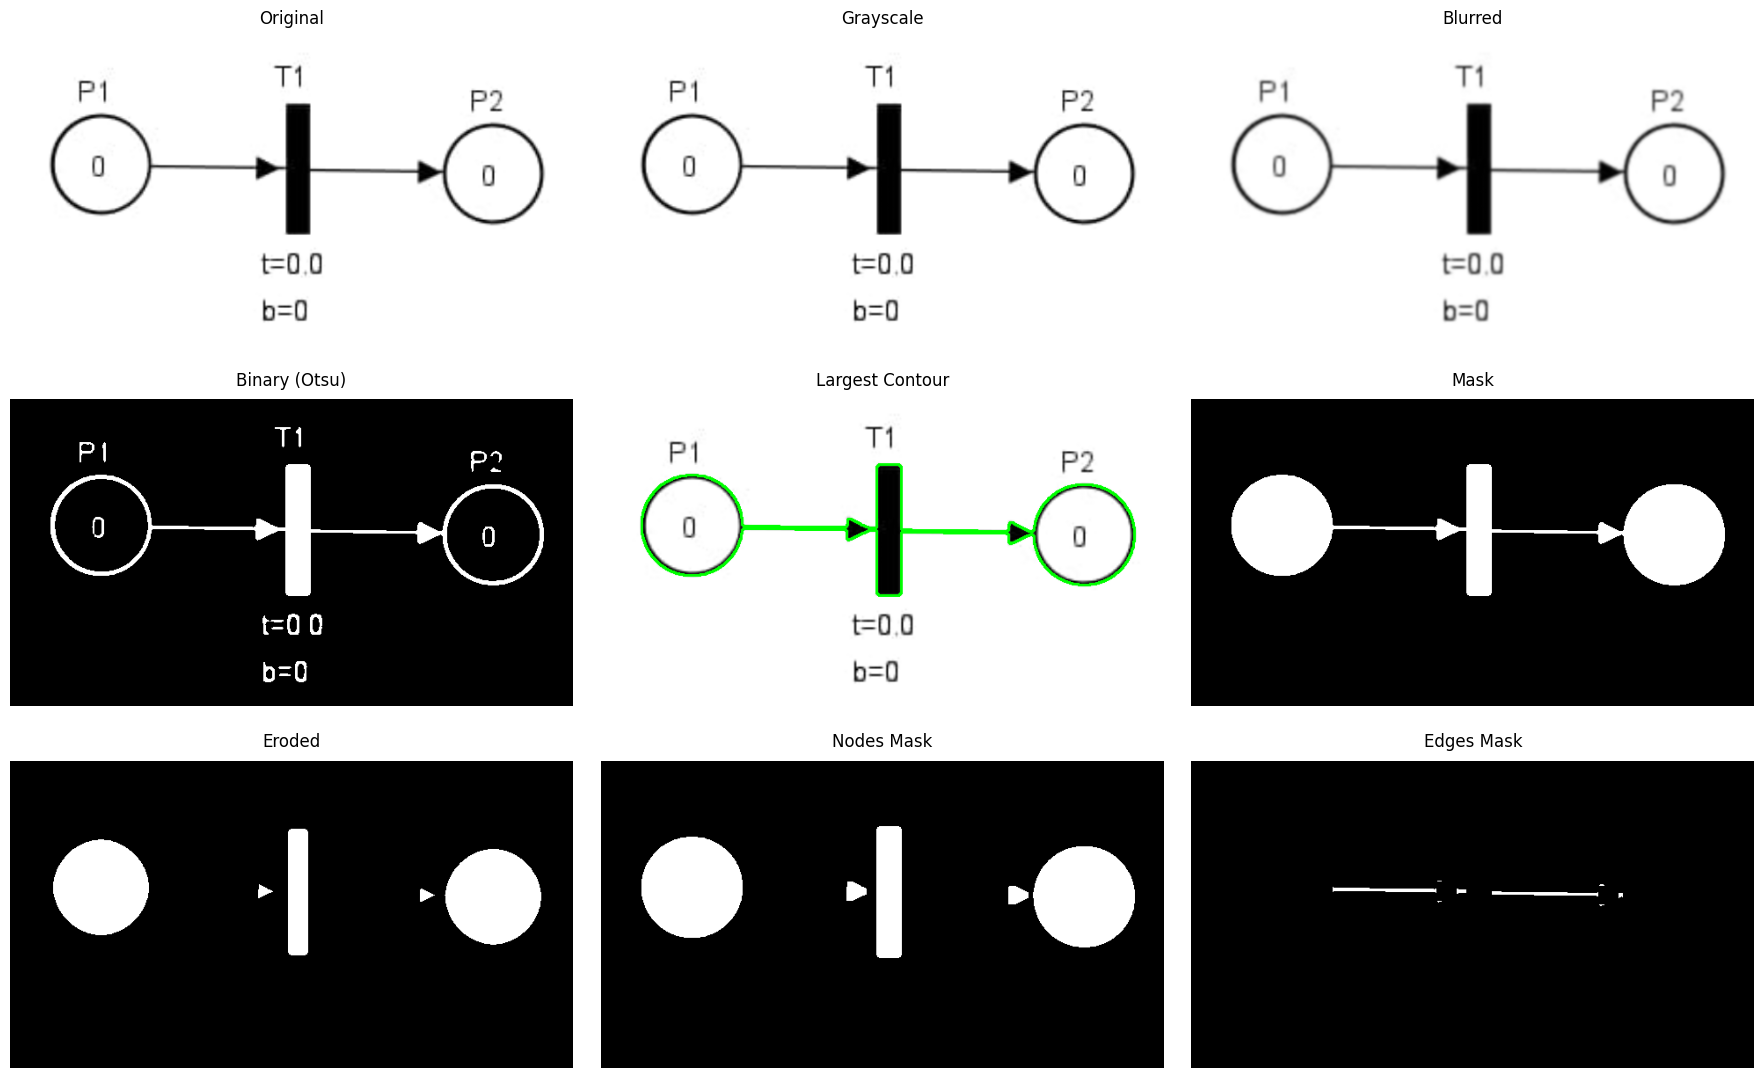

In [6]:

### ATTEMPT 1

# view_image(r'assets/local/simple_petri_1.jpg', 'Original Image')
# Helper function to display multiple images in a row
def display_images(images, titles, rows=1, figsize=(15, 10)):
    """
    Display multiple images with their titles in a grid.
    
    Args:
        images: List of images to display
        titles: List of titles for the images
        rows: Number of rows in the grid
        figsize: Figure size
    """
    cols = len(images) // rows + (1 if len(images) % rows != 0 else 0)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]
    
    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 2:  # Grayscale
            axes[i].imshow(image, cmap='gray')
        else:  # Color
            axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title, pad=10)  # Add padding below the title
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout(pad=2.0, h_pad=4.0, w_pad=2.0)  # Add padding between subplots
    plt.subplots_adjust(top=0.9)  # Add more space at the top
    plt.show()

# 2. Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 3. Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 4. Apply Otsu's thresholding
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 5. Find contours and get the largest contour
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# 6. Create mask from the largest contour
graph_mask = np.zeros_like(gray)
cv2.drawContours(graph_mask, [largest_contour], 0, 255, -1)

# 7. Apply erosion (fixed the undefined variable issue)
kernel = np.ones((3, 3), np.uint8)
eroded = cv2.erode(graph_mask, kernel, iterations=3)

# 8. Dilate to restore node size
nodes_mask = cv2.dilate(eroded, kernel, iterations=3)

# 9. Create edges mask by subtracting nodes from original binary
edges_mask = cv2.subtract(graph_mask, nodes_mask)

display_images(
    [image, gray, blurred, binary, 
     cv2.drawContours(image.copy(), [largest_contour], 0, (0, 255, 0), 2),
     graph_mask, eroded, nodes_mask, edges_mask],
    ["Original", "Grayscale", "Blurred", "Binary (Otsu)", 
     "Largest Contour", "Mask", "Eroded", "Nodes Mask", "Edges Mask"],
    rows=3,
    figsize=(18, 12)  # Increased figure size
)

In [6]:
def apply_erosion(kernel_size=3, iterations=1):
    clear_output(wait=True)
    
    # Ensure kernel size is odd
    # kernel_size = max(1, kernel_size if kernel_size % 2 == 1 else kernel_size + 1)
    
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    eroded = cv2.erode(graph_mask, kernel, iterations=iterations)
    
    view_image(eroded)

# Create interactive widget
interact(
    apply_erosion,
    kernel_size=IntSlider(min=1, max=15, step=1, value=3, description='Kernel Size'),
    iterations=IntSlider(min=1, max=10, step=1, value=1, description='Iterations')
)

interactive(children=(IntSlider(value=3, description='Kernel Size', max=15, min=1), IntSlider(value=1, descrip…

<function __main__.apply_erosion(kernel_size=3, iterations=1)>

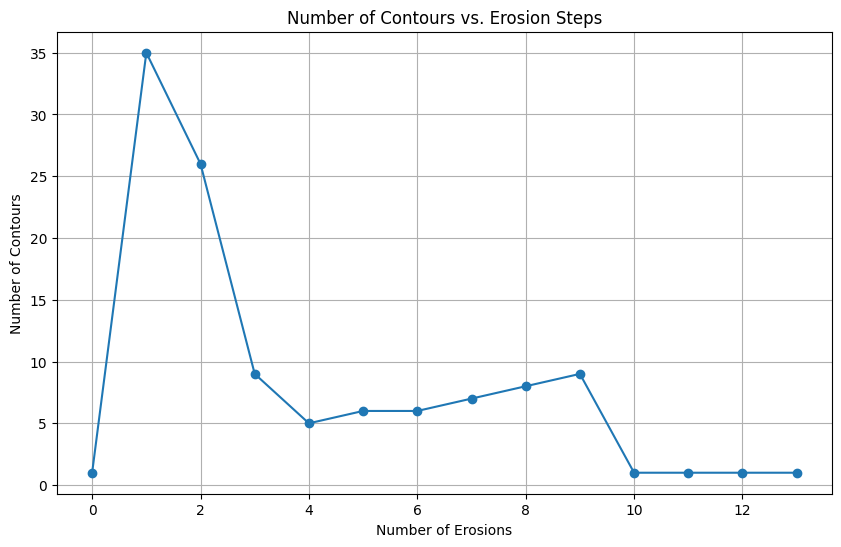

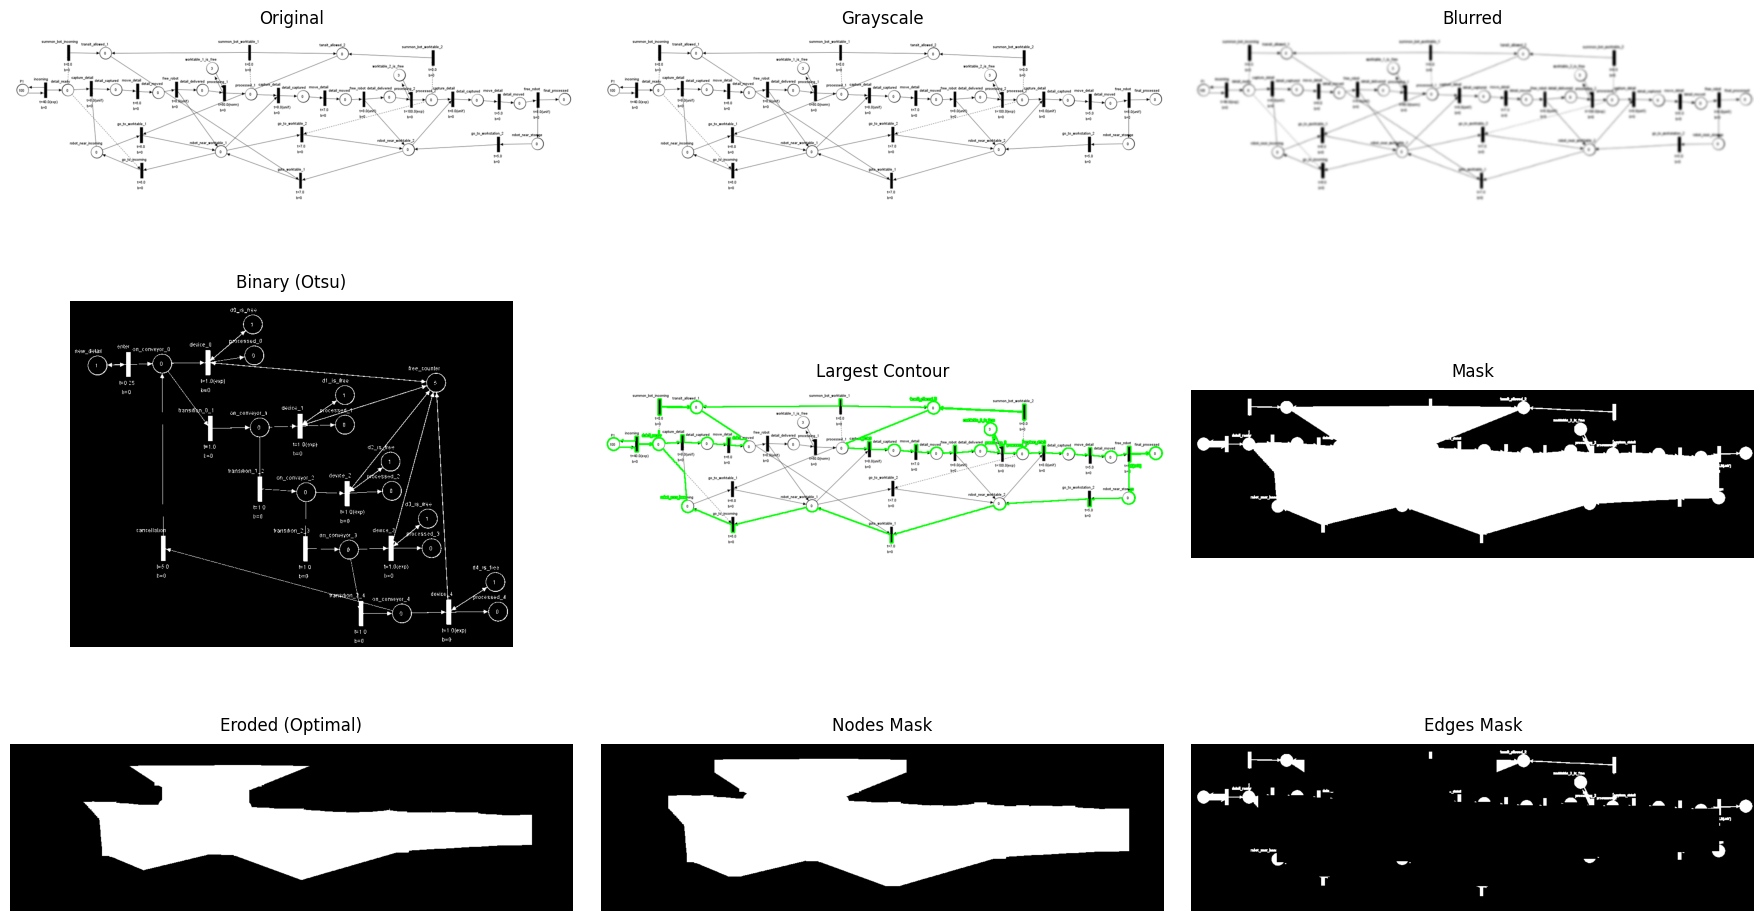

In [37]:
# 2. Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 3. Apply Gaussian blur
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 4. Apply Otsu's thresholding
# _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

inverted_gray = cv2.bitwise_not(gray)

# 5. Find contours and get the largest contour
contours, hierarchy = cv2.findContours(inverted_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# 6. Create mask from the largest contour
graph_mask = np.zeros_like(gray)
cv2.drawContours(graph_mask, [largest_contour], 0, 255, -1)

# 7. Determine optimal number of erosions using contour stabilization heuristic
kernel = np.ones((3, 3), np.uint8)
current_mask = graph_mask.copy()
contour_counts = []
num_erosions = 0
stabilization_steps = 3  # Number of consecutive stable steps to stop
stable_count = 0
previous_count = None

while True:
    # Find contours in the current mask
    contours, _ = cv2.findContours(current_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    current_count = len(contours)
    contour_counts.append(current_count)
    
    # Check if the count has stabilized
    if previous_count is not None:
        if current_count == previous_count:
            stable_count += 1
        else:
            stable_count = 0
    
    previous_count = current_count
    
    # Stop if stabilized for required steps or if max steps reached (prevent infinite loop)
    if stable_count >= stabilization_steps:
        break
    
    # Apply erosion
    current_mask = cv2.erode(current_mask, kernel, iterations=1)
    num_erosions += 1

# The eroded mask after optimal erosions
eroded = current_mask

# 8. Dilate to restore node size (using the same number of iterations)
nodes_mask = cv2.dilate(eroded, kernel, iterations=num_erosions)

# 9. Create edges mask by subtracting nodes from original binary
edges_mask = cv2.subtract(graph_mask, nodes_mask)

# Plotting the erosion steps vs. contour counts
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(contour_counts)), contour_counts, marker='o', linestyle='-')
plt.xlabel('Number of Erosions')
plt.ylabel('Number of Contours')
plt.title('Number of Contours vs. Erosion Steps')
plt.grid(True)
plt.show()

display_images(
    [image, gray, blurred, binary, 
     cv2.drawContours(image.copy(), [largest_contour], 0, (0, 255, 0), 2),
     graph_mask, eroded, nodes_mask, edges_mask],
    ["Original", "Grayscale", "Blurred", "Binary (Otsu)", 
     "Largest Contour", "Mask", "Eroded (Optimal)", "Nodes Mask", "Edges Mask"],
    rows=3,
    figsize=(18, 12)
)

### Contours

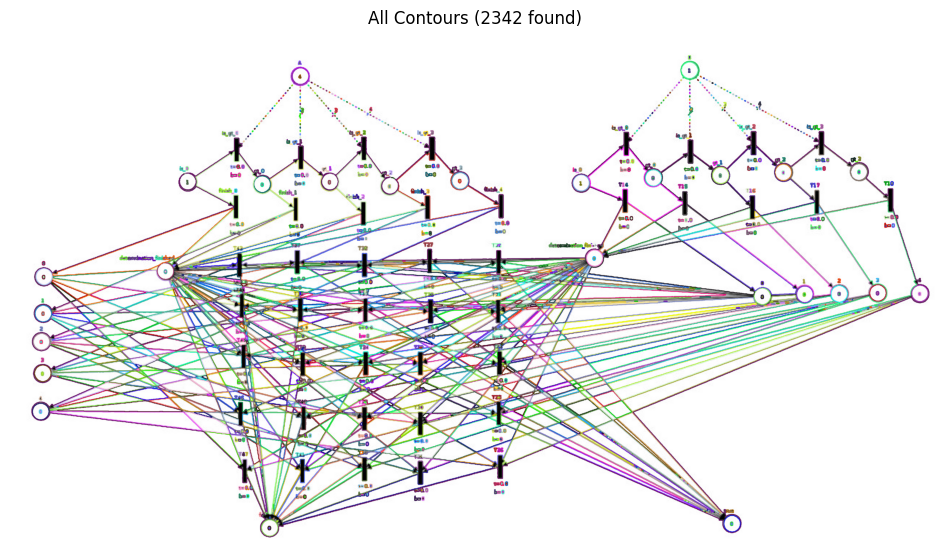

Found 2342 contours


In [16]:
# # 2. Otsu's method
_, otsu_thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

## Find all contours
contours, hierarchy = cv2.findContours(otsu_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

result = image.copy()
for i, contour in enumerate(contours):
    color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
    cv2.drawContours(result, [contour], -1, color, 2)

# Convert to RGB for matplotlib display
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(12, 10))
plt.imshow(result_rgb)
plt.title(f'All Contours ({len(contours)} found)')
plt.axis('off')
plt.show()

print(f"Found {len(contours)} contours")


In [11]:
def is_circle_enclosing(contour, threshold):
    (x, y), radius = cv2.minEnclosingCircle(contour)
    enclosing_area = np.pi * (radius ** 2)
    contour_area = cv2.contourArea(contour)
    
    return contour_area / enclosing_area > threshold 

def is_circle_circularity(contour, threshold): #TODO: add threshold
        # Calculate contour area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Calculate circularity - a perfect circle has circularity = 1
    # Formula: 4π × Area/Perimeter²
    if perimeter == 0:
        return False
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    
    # Consider additional criteria for better circle detection
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Filter based on circularity and other optional criteria
    return circularity > 0.8 and 0.8 < aspect_ratio < 1.2 and area > 50

def is_circle_hough(contour, threshold):
    x, y, w, h = cv2.boundingRect(contour)

    # Create a blank image slightly larger than the contour
    padding = 10
    mask = np.zeros((h + 2*padding, w + 2*padding), dtype=np.uint8)

    # Shift the contour to fit in the blank image
    shifted_contour = contour.copy()
    shifted_contour[:, :, 0] = contour[:, :, 0] - x + padding
    shifted_contour[:, :, 1] = contour[:, :, 1] - y + padding

    # Draw just the contour on the blank image
    cv2.drawContours(mask, [shifted_contour], -1, 255, 1)

    # Ensure input is grayscale (HoughCircles requires single-channel)    
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # Detect circles
    circles = cv2.HoughCircles(
        mask, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20, 
        param1=5, 
        param2=25, 
        minRadius=5, 
        maxRadius=95
    )

    return circles is not None
    
    

In [70]:
is_circle_hough(contours[1979], 0.5)

True

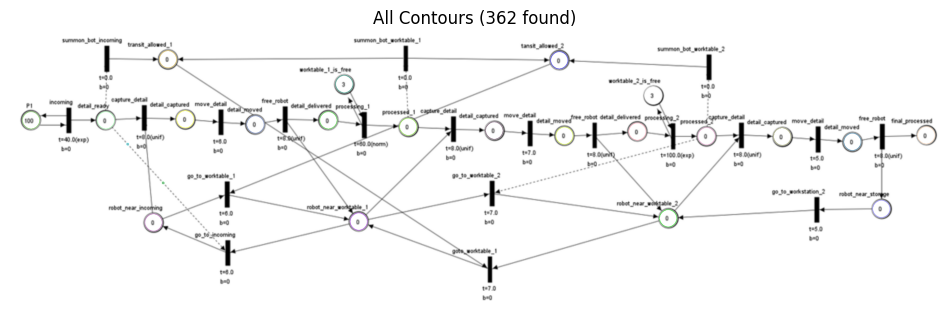

Found 22 circular contours out of 362 total contours
Circular contours indices: [37, 40, 44, 59, 87, 187, 218, 226, 227, 230, 231, 239, 243, 255, 265, 275, 276, 278, 283, 334, 347, 348]
Contour 37: position=(995,1345), size=129x129, area=12540.5
Contour 40: position=(2509,1339), size=128x129, area=12491.0
Contour 44: position=(4790,1315), size=132x129, area=12594.0
Contour 59: position=(6365,1246), size=130x129, area=12605.5
Contour 87: position=(1123,1111), size=15x15, area=176.0


In [29]:
# # 2. Otsu's method
_, otsu_thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Apply one pass of dilation to improve connectivity
kernel = np.ones((3, 3), np.uint8)
otsu_dilated = cv2.dilate(otsu_thresh, kernel, iterations=3)

# Save the dilated image to a file in the postprocessed folder
cv2.imwrite(f'../assets/postprocessed/{get_variable_name(otsu_dilated)}.png', otsu_dilated)

## Find all contours
contours, hierarchy = cv2.findContours(otsu_dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw on
result = image.copy()
circular_contours = dict()

# Filter for circular contours
for i, contour in enumerate(contours):
    if is_circle_enclosing(contour, 0.8):
        circular_contours[i] = contour
        # Generate a random color for each contour
        color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        cv2.drawContours(result, [contour], -1, color, 2)
        



# Convert to RGB for matplotlib display
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(12, 10))
plt.imshow(result_rgb)
plt.title(f'All Contours ({len(contours)} found)')
plt.axis('off')
plt.show()

cv2.imwrite(f'../assets/postprocessed/{get_variable_name(result_rgb)}.png', result_rgb)


print(f"Found {len(circular_contours)} circular contours out of {len(contours)} total contours")
# Print summary of circular contours instead of the full arrays
print(f"Circular contours indices: {list(circular_contours.keys())}")

# If you want to see some properties of each contour:
for idx, contour in list(circular_contours.items())[:5]:  # Show first 5 contours only
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    print(f"Contour {idx}: position=({x},{y}), size={w}x{h}, area={area}")

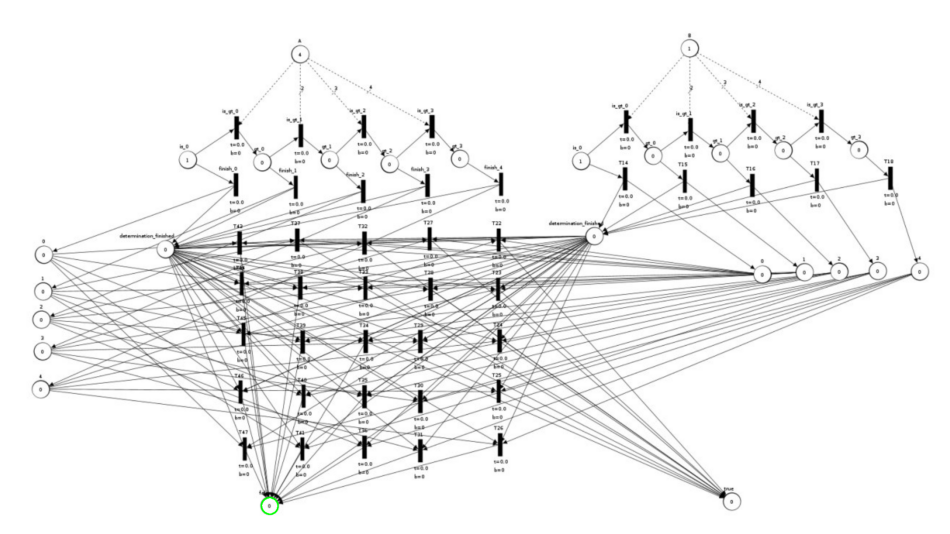

In [35]:

# Create a copy of the original image to draw on
result = image.copy()

color = (0, 255, 0)  # Green color for drawing
cv2.drawContours(result, [circular_contours[5]], -1, color, 2)

result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 10))
plt.imshow(result_rgb)
plt.axis('off')
plt.show()

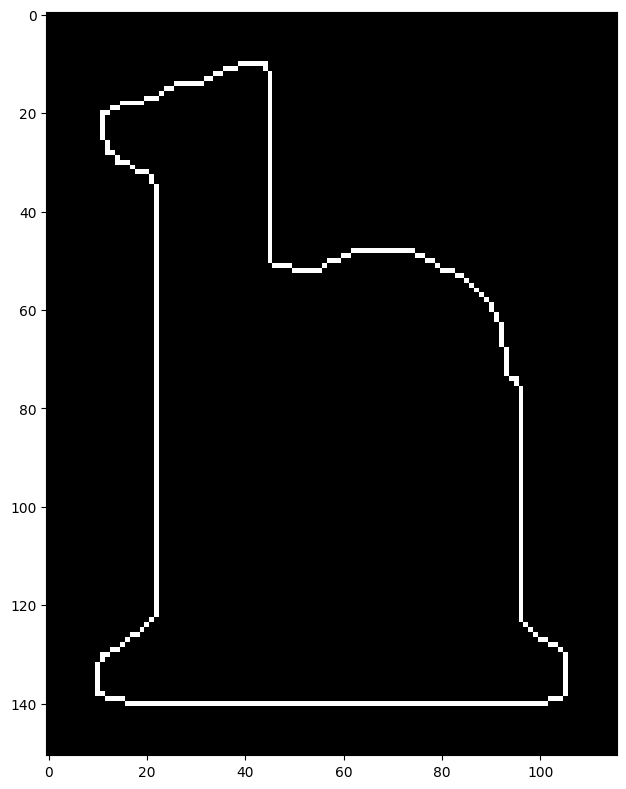

Contour properties:
Position: (2309, 1774)
Dimensions: 96x131
Area: 7772.50 pixels²
Perimeter: 445.44 pixels
Circularity: 0.4923 (1.0 = perfect circle)


In [6]:
def display_isolated_contour(contour):
    
    # Get bounding rectangle to determine size
    x, y, w, h = cv2.boundingRect(contour)
    
    # Create a blank image slightly larger than the contour
    padding = 10
    mask = np.zeros((h + 2*padding, w + 2*padding), dtype=np.uint8)
    
    # Shift the contour to fit in the blank image
    shifted_contour = contour.copy()
    shifted_contour[:, :, 0] = contour[:, :, 0] - x + padding
    shifted_contour[:, :, 1] = contour[:, :, 1] - y + padding
    
    # Draw just the contour on the blank image
    cv2.drawContours(mask, [shifted_contour], -1, 255, 1)
    
    # Display the isolated contour
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    plt.axis('on')
    plt.tight_layout()
    plt.show()
    
    # Print some information about the contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
    
    print(f"Contour properties:")
    print(f"Position: ({x}, {y})")
    print(f"Dimensions: {w}x{h}")
    print(f"Area: {area:.2f} pixels²")
    print(f"Perimeter: {perimeter:.2f} pixels")
    print(f"Circularity: {circularity:.4f} (1.0 = perfect circle)")
    return mask

# Use the function to display the 5th circular contour
mask = display_isolated_contour(contours[5])

### Hough transform
It looks like we would have to remove all the text 

In [7]:
def find_circles(image, min_radius=5, max_radius=20, param1=50, param2=30):
    # Ensure input is grayscale (HoughCircles requires single-channel)
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect circles
    circles = cv2.HoughCircles(
        image, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20, 
        param1=param1, 
        param2=param2, 
        minRadius=min_radius, 
        maxRadius=max_radius
    )

    if circles is not None:
        # Convert coordinates and radius to integers
        circles = np.uint16(np.around(circles))
        
        # Create a color version of the image for drawing
        if len(image.shape) == 2:
            result_hough = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            result_hough = image.copy()
        
        # Draw detected circles
        for i in circles[0, :]:
            # Draw outer circle (green)
            cv2.circle(result_hough, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw center (red)
            cv2.circle(result_hough, (i[0], i[1]), 2, (0, 0, 255), 3)
        
        # Convert BGR to RGB for matplotlib
        result_hough_rgb = cv2.cvtColor(result_hough, cv2.COLOR_BGR2RGB)
        
        # Display results
        plt.figure(figsize=(12, 10))
        plt.imshow(result_hough_rgb)
        plt.title(f'Circles Detected (Hough Transform) - {len(circles[0])} found')
        plt.axis('off')
        plt.show()
    else:
        print("No circles detected!")

interact(
    find_circles,
    image=fixed(mask),
    min_radius=IntSlider(min=0, max=100, step=1, value=5, description='Min Radius'),
    max_radius=IntSlider(min=0, max=100, step=1, value=95, description='Max Radius'),
    param1=IntSlider(min=0, max=200, step=1, value=2, description='Param 1'),
    param2=IntSlider(min=0, max=200, step=1, value=25, description='Param 2')
)

interactive(children=(IntSlider(value=5, description='Min Radius'), IntSlider(value=95, description='Max Radiu…

<function __main__.find_circles(image, min_radius=5, max_radius=20, param1=50, param2=30)>